In [12]:
import pandas as pd
import os
from simulated_data_experiments.DataGenerator import DataGenerator
from simulated_data_experiments.constants_sim import RANDOM_SEED, PARAMS
from utils import run_IL_lin

# XGBoost imports
from expectation_xgb.experiment import XGBoostExperiment
from expectation_xgb.final_model import FinalXGB

from error_correction import ErrorRegressor
from utils import aggregate_results, aggregate_feature_importances, \
    aggregate_residuals
from plotting import feature_importance_plot, plot_reg_perf, plot_residuals
from expectation_xgb.constants import CV_FOLDS, OPTUNA__N_JOBS, XGB__NTHREAD, \
    N_ESTIMATORS, EARLY_STOPPING_ROUNDS, OBJECTIVE, XGB_HP

### Load data
For this example, we simulate a dataset.

X_train: Samples unaffected by the construct of interest (COI)\
y_train: Observed outcomes of the samples in X_train\
X_test: Samples affected by the COI\
y_test: Observed outcomes of the samples in X_test\
y_test_no_coi: 'Expectation' component of the observed outcomes of the samples in X_test\
coi_component: 'COI' component of the observed outcomes of the samples in X_test\
coefs: Coefficients of the linear model used to simulate the 'expectation' component\
coi_coefs: Coefficients of the linear model used to simulate the 'COI' component\

In real data, only X_train, y_train, X_test, and y_test are available. The goal is to estimate the 'COI' component of the observed outcomes of the samples in X_test.

In [7]:
# path to save the results of hyperparameter tuning and the final 'expectation' models
save_path = '../example_run'

dg = DataGenerator(random_seed=RANDOM_SEED)
X_train, y_train, X_test, y_test, y_test_no_coi, coi_component, coefs, coi_coefs = dg.generate_linear_data(**PARAMS)

### Apply a linear 'expectation' model within the inverse learning framework
We train a simple linear model to predict the 'expectation' component of the observed outcomes and directly extract the 'COI' component as the residuals.

In [8]:
# wrapper function that trains & runs the model and returns the residuals and prediction CV performance
IL_lin_results = run_IL_lin(X_train, X_test, y_train, y_test, with_correction=True)

print("CV performance: ", IL_lin_results[1])
IL_lin_results[0] # residuals, predictions, and observed values per sample in X_test

CV performance:  0    1.0
Name: ExpVar_val, dtype: object


,Label,Prediction,Residual,Corrected
330,-8.962641,-6.635899,-2.326742,-2.326742
331,-15.583336,-16.447328,0.863992,0.863992
332,-16.130696,-14.088288,-2.042409,-2.042409
333,-44.905174,-24.337356,-20.567818,-20.567818
334,1.276332,-4.757166,6.033498,6.033498
...,...,...,...,...
995,-4.870399,10.013308,-14.883707,-14.883707
996,19.239686,-3.575150,22.814836,22.814836
997,-3.638411,-10.795736,7.157325,7.157325
998,-1.635269,10.410479,-12.045748,-12.045748


### Train a nonlinear xgboost 'expectation' model

In [5]:
OPTUNA__N_TRIALS = 10
REPEATS = 2
NUMERICAL = X_train.columns
CATEGORICAL = []

# Create the directory for the xgboost results
xgb_save_path = f"{save_path}/xgboost_exp"
os.makedirs(xgb_save_path, exist_ok=True)

exp = XGBoostExperiment(xgb_save_path, X_train, y_train, NUMERICAL, 
                        CATEGORICAL, CV_FOLDS, OBJECTIVE, XGB_HP, OPTUNA__N_TRIALS, 
                        OPTUNA__N_JOBS, XGB__NTHREAD, N_ESTIMATORS, EARLY_STOPPING_ROUNDS)
exp.run(repeats=REPEATS)

# aggregate the results across repeats
mean_result = aggregate_results(xgb_save_path)
mean_result.to_csv(f"{xgb_save_path}/mean_results.out")
res_results = aggregate_residuals(xgb_save_path)
res_results.to_csv(f"{xgb_save_path}/residuals.out")
feat_imps = aggregate_feature_importances(xgb_save_path)
# plots
feature_importance_plot(feat_imps, xgb_save_path)
plot_reg_perf(mean_result, xgb_save_path, show=True, close=False)

[I 2024-08-16 14:09:10,468] Using an existing study with name 'xGBoost' instead of creating a new one.



Running outer fold 0


[14:09:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[14:09:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

/Users/cbirkenbihl/git/inverse_learning/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cbirkenbihl/git/inverse_learning/.conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[14:09:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

/Users/cbirkenbihl/git/inve

KeyboardInterrupt: 

#### Investigate performance

In [9]:
xgb_save_path = f"{save_path}/xgboost_exp"
xgbfinal_save_path = f"{save_path}/xgb_final_cvhpo"

# create directory if it does not exist
if not os.path.exists(xgbfinal_save_path):
    os.makedirs(xgbfinal_save_path)

final = FinalXGB(xgbfinal_save_path, X_train, y_train, X_train.columns, [], CV_FOLDS, 
                OBJECTIVE, XGB_HP, OPTUNA__N_TRIALS, OPTUNA__N_JOBS,
                XGB__NTHREAD, N_ESTIMATORS, EARLY_STOPPING_ROUNDS, repeats=5)
final.train(exp_glob_pattern=f"{xgb_save_path}/repeat-*/params.json")
res_test, _ = final.test(X_test, y_test)

  0%|          | 0/5 [00:00<?, ?it/s]/Users/cbirkenbihl/git/inverse_learning/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:14:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
 20%|██        | 1/5 [00:00<00:00,  6.76it/s]/Users/cbirkenbihl/git/inverse_learning/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:14:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
 40%|████      | 2/5 [00:00<00:00,  7.59it/s]

Done training model 0
Done training model 1


/Users/cbirkenbihl/git/inverse_learning/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:14:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
 60%|██████    | 3/5 [00:00<00:00,  7.55it/s]/Users/cbirkenbihl/git/inverse_learning/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:14:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
 80%|████████  | 4/5 [00:00<00:00,  7.74it/s]

Done training model 2
Done training model 3


/Users/cbirkenbihl/git/inverse_learning/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:14:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
100%|██████████| 5/5 [00:00<00:00,  7.64it/s]

Done training model 4


#### Run 'expectation' model

In [10]:
xgb_save_path = f"{save_path}/xgboost_exp"
xgbfinal_save_path = f"{save_path}/xgb_final_cvhpo"

# create save directory if it does not exist
if not os.path.exists(xgbfinal_save_path):
    os.makedirs(xgbfinal_save_path)

final = FinalXGB(xgbfinal_save_path, X_train, y_train, X_train.columns, [], CV_FOLDS, 
                OBJECTIVE, XGB_HP, OPTUNA__N_TRIALS, OPTUNA__N_JOBS,
                XGB__NTHREAD, N_ESTIMATORS, EARLY_STOPPING_ROUNDS, repeats=2)
final.train(exp_glob_pattern=f"{xgb_save_path}/repeat-*/params.json") # load hyperparameters from the previous experiment
res_test, _ = final.test(X_test, y_test) # get predictions and residuals
res_test

  0%|          | 0/2 [00:00<?, ?it/s]/Users/cbirkenbihl/git/inverse_learning/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:14:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
 50%|█████     | 1/2 [00:00<00:00,  7.71it/s]/Users/cbirkenbihl/git/inverse_learning/.conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:14:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
100%|██████████| 2/2 [00:00<00:00,  7.99it/s]

Done training model 0
Done training model 1


,Label,Pred_m0,Res_m0,Pred_m1,Res_m1,Prediction_mean,Residual_mean
330,-8.962641,-17.964056,9.001415,-17.964056,9.001415,-17.964056,9.001415
331,-15.583336,-12.529897,-3.053440,-12.529897,-3.053440,-12.529897,-3.053440
332,-16.130696,-8.938561,-7.192135,-8.938561,-7.192135,-8.938561,-7.192135
333,-44.905174,-14.498558,-30.406616,-14.498558,-30.406616,-14.498558,-30.406616
334,1.276332,-7.467665,8.743997,-7.467665,8.743997,-7.467665,8.743997
...,...,...,...,...,...,...,...
995,-4.870399,2.235354,-7.105752,2.235354,-7.105752,2.235354,-7.105752
996,19.239686,-5.154327,24.394013,-5.154327,24.394013,-5.154327,24.394013
997,-3.638411,-3.800747,0.162335,-3.800747,0.162335,-3.800747,0.162335
998,-1.635269,4.834439,-6.469708,4.834439,-6.469708,4.834439,-6.469708


### Train and run 'error correction' model

In [11]:
# Get CV error of 'expectation' model
train_res = aggregate_residuals(xgb_save_path)
# train 'error correction' model
residual_regressor = ErrorRegressor(numerical=X_train.columns, imp_iter=25)
residual_regressor.fit(X_train, train_res["Residual_mean"])
# get the corrected residuals
corr_residuals_table = residual_regressor.clean_residuals(X_test, res_test["Residual_mean"])
corr_residuals_table

,Residual,Pred_Error,Corrected,Corrected_SD
330,9.001415,1.285904,7.715511,0.502380
331,-3.053440,-5.610709,2.557269,0.166511
332,-7.192135,-2.145876,-5.046259,-0.328577
333,-30.406616,-6.760115,-23.646501,-1.539694
334,8.743997,1.130004,7.613994,0.495770
...,...,...,...,...
995,-7.105752,4.091659,-11.197412,-0.729097
996,24.394013,0.047125,24.346887,1.585299
997,0.162335,-1.671688,1.834024,0.119419
998,-6.469708,5.837489,-12.307197,-0.801358


### Plotting Residuals

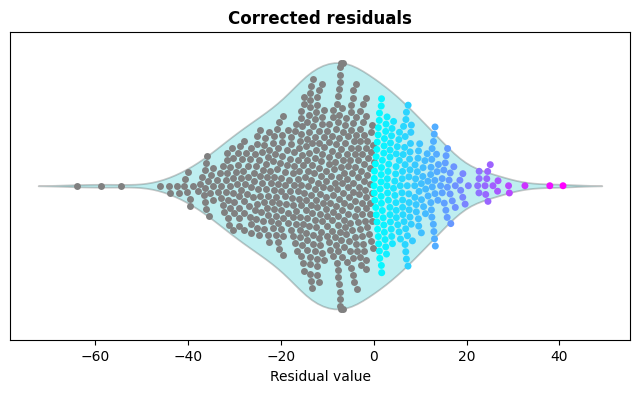

In [20]:
plot_residuals(corr_residuals_table)